In [33]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
from torch import device
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import spectral_norm

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [36]:
!unzip -qq ./drive/MyDrive/punk/punk.zip 

replace imgs/imgs/0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [37]:
image_size = 64
batch_size = 128
latent_size= 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)


train_ds = ImageFolder('imgs', transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [38]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [39]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

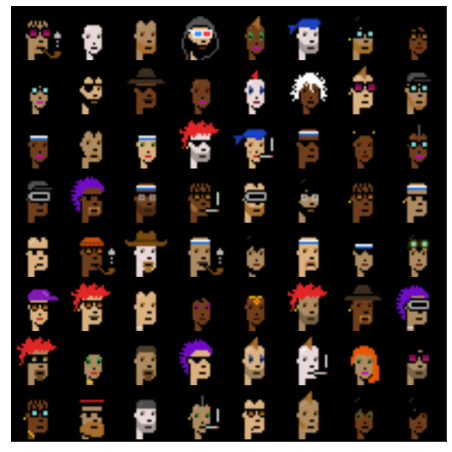

In [40]:
show_batch(train_dl)

In [41]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [42]:
device = get_default_device()
device

device(type='cuda')

In [43]:
train_dl = DeviceDataLoader(train_dl, device)

In [44]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1
    
    # Modification 1: remove sigmoid
    # nn.Sigmoid()

    )

In [45]:
discriminator = to_device(discriminator, device)

In [46]:
latent_size = 128

In [47]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [48]:
def weight_init(m):
    # weight_initialization: important for wgan
    class_name=m.__class__.__name__
    if class_name.find('Conv')!=-1:
        m.weight.data.normal_(0,0.02)
    elif class_name.find('Norm')!=-1:
        m.weight.data.normal_(1.0,0.02)

In [49]:
discriminator.apply(weight_init)
generator.apply(weight_init)

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

torch.Size([128, 3, 64, 64])


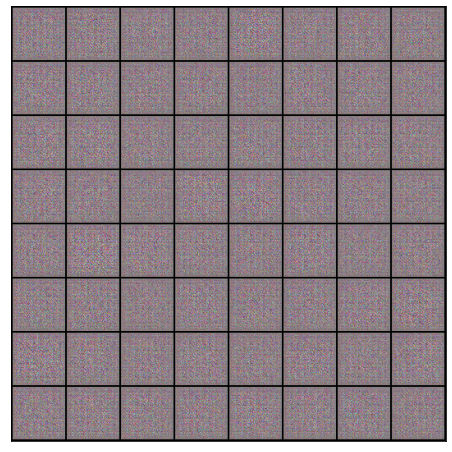

In [50]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [51]:
generator = to_device(generator, device)

In [52]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    #modification: remove binary cross entropy
        #real_targets = torch.ones(real_images.size(0), 1, device=device)
        #real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_loss = -torch.mean(real_preds)
        
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    #modification: remove binary cross entropy
        #fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
        #fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_loss = torch.mean(fake_preds)

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_loss.item(), fake_loss.item()

In [53]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    #modificationL remove binary cross entropy
        #targets = torch.ones(batch_size, 1, device=device)
    loss = -torch.mean(preds)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [54]:
sample_dir = 'generated1'
os.makedirs(sample_dir, exist_ok=True)

In [55]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [56]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


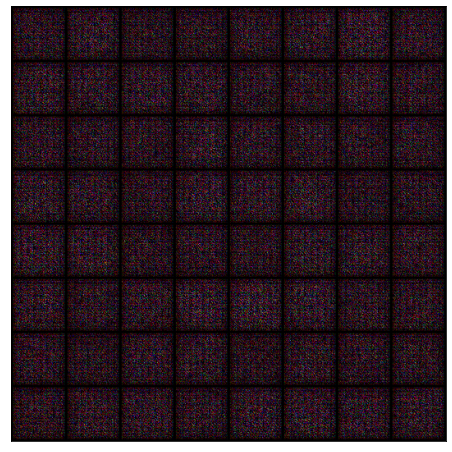

In [57]:
save_samples(0, fixed_latent)

In [61]:
def fit(epochs, lr, start_idx=1):
    # torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # # Create optimizers
    opt_d = torch.optim.RMSprop(discriminator.parameters(), lr=lr)
    opt_g = torch.optim.RMSprop(generator.parameters(), lr=lr)
    
    
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # modification: clip param for discriminator
            for parm in discriminator.parameters():
                parm.data.clamp_(-clamp_num, clamp_num)
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [62]:
lr = 0.00005
epochs = 100
clamp_num=0.01# WGAN clip gradient

In [63]:
history = fit(epochs, lr)

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 0.3667, loss_d: -0.6602, real_score: -0.1028, fake_score: -0.5574
Saving generated-images-0001.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 0.5506, loss_d: -0.5828, real_score: -0.3601, fake_score: -0.2227
Saving generated-images-0002.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 0.2888, loss_d: -0.7507, real_score: -0.1993, fake_score: -0.5515
Saving generated-images-0003.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 0.5361, loss_d: -0.6255, real_score: -0.4124, fake_score: -0.2131
Saving generated-images-0004.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 0.4679, loss_d: -0.4844, real_score: -0.3254, fake_score: -0.1590
Saving generated-images-0005.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 0.2545, loss_d: -0.5163, real_score: -0.0416, fake_score: -0.4747
Saving generated-images-0006.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 0.1794, loss_d: -0.5280, real_score: -0.1388, fake_score: -0.3892
Saving generated-images-0007.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 0.5364, loss_d: -0.5015, real_score: -0.4422, fake_score: -0.0593
Saving generated-images-0008.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 0.1291, loss_d: -0.5260, real_score: -0.0459, fake_score: -0.4801
Saving generated-images-0009.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 0.5175, loss_d: -0.5532, real_score: -0.4493, fake_score: -0.1039
Saving generated-images-0010.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 0.0714, loss_d: -0.4535, real_score: 0.0377, fake_score: -0.4912
Saving generated-images-0011.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 0.4994, loss_d: -0.4988, real_score: -0.4144, fake_score: -0.0845
Saving generated-images-0012.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 0.0919, loss_d: -0.5875, real_score: -0.1178, fake_score: -0.4697
Saving generated-images-0013.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 0.5235, loss_d: -0.5996, real_score: -0.4190, fake_score: -0.1806
Saving generated-images-0014.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 0.1898, loss_d: -0.5696, real_score: -0.0901, fake_score: -0.4794
Saving generated-images-0015.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 0.5037, loss_d: -0.6126, real_score: -0.4155, fake_score: -0.1971
Saving generated-images-0016.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 0.3188, loss_d: -0.6448, real_score: -0.1156, fake_score: -0.5293
Saving generated-images-0017.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 0.4844, loss_d: -0.6097, real_score: -0.4263, fake_score: -0.1834
Saving generated-images-0018.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 0.1826, loss_d: -0.6003, real_score: -0.0601, fake_score: -0.5403
Saving generated-images-0019.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 0.5486, loss_d: -0.6373, real_score: -0.4719, fake_score: -0.1654
Saving generated-images-0020.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 0.5146, loss_d: -0.6116, real_score: -0.4468, fake_score: -0.1648
Saving generated-images-0021.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 0.3059, loss_d: -0.7025, real_score: -0.2438, fake_score: -0.4586
Saving generated-images-0022.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 0.1597, loss_d: -0.5880, real_score: -0.0668, fake_score: -0.5212
Saving generated-images-0023.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 0.5328, loss_d: -0.7013, real_score: -0.4748, fake_score: -0.2265
Saving generated-images-0024.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 0.1364, loss_d: -0.5534, real_score: -0.0030, fake_score: -0.5504
Saving generated-images-0025.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 0.4503, loss_d: -0.7413, real_score: -0.3972, fake_score: -0.3441
Saving generated-images-0026.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 0.2642, loss_d: -0.7046, real_score: -0.1696, fake_score: -0.5350
Saving generated-images-0027.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 0.5685, loss_d: -0.6941, real_score: -0.4986, fake_score: -0.1955
Saving generated-images-0028.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 0.3263, loss_d: -0.8252, real_score: -0.3245, fake_score: -0.5007
Saving generated-images-0029.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 0.2132, loss_d: -0.7308, real_score: -0.2240, fake_score: -0.5068
Saving generated-images-0030.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 0.5412, loss_d: -0.7130, real_score: -0.5013, fake_score: -0.2116
Saving generated-images-0031.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 0.1668, loss_d: -0.7600, real_score: -0.2364, fake_score: -0.5236
Saving generated-images-0032.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 0.5431, loss_d: -0.6476, real_score: -0.4659, fake_score: -0.1817
Saving generated-images-0033.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 0.2002, loss_d: -0.6537, real_score: -0.1235, fake_score: -0.5302
Saving generated-images-0034.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 0.5599, loss_d: -0.7592, real_score: -0.5124, fake_score: -0.2468
Saving generated-images-0035.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 0.5001, loss_d: -0.6708, real_score: -0.4472, fake_score: -0.2236
Saving generated-images-0036.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 0.5124, loss_d: -0.7805, real_score: -0.4598, fake_score: -0.3207
Saving generated-images-0037.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 0.0885, loss_d: -0.6531, real_score: -0.1126, fake_score: -0.5405
Saving generated-images-0038.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 0.4910, loss_d: -0.6809, real_score: -0.4291, fake_score: -0.2518
Saving generated-images-0039.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 0.1700, loss_d: -0.6993, real_score: -0.1789, fake_score: -0.5204
Saving generated-images-0040.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 0.5063, loss_d: -0.7137, real_score: -0.4431, fake_score: -0.2706
Saving generated-images-0041.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 0.3405, loss_d: -0.7086, real_score: -0.2948, fake_score: -0.4138
Saving generated-images-0042.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 0.2090, loss_d: -0.6894, real_score: -0.1754, fake_score: -0.5140
Saving generated-images-0043.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 0.5418, loss_d: -0.6814, real_score: -0.4698, fake_score: -0.2116
Saving generated-images-0044.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 0.3677, loss_d: -0.7858, real_score: -0.2398, fake_score: -0.5460
Saving generated-images-0045.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 0.5097, loss_d: -0.7122, real_score: -0.4477, fake_score: -0.2645
Saving generated-images-0046.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 0.2249, loss_d: -0.7684, real_score: -0.2395, fake_score: -0.5289
Saving generated-images-0047.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 0.3885, loss_d: -0.7925, real_score: -0.3474, fake_score: -0.4451
Saving generated-images-0048.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 0.4558, loss_d: -0.7316, real_score: -0.3755, fake_score: -0.3562
Saving generated-images-0049.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 0.2633, loss_d: -0.8085, real_score: -0.2468, fake_score: -0.5617
Saving generated-images-0050.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 0.1883, loss_d: -0.6432, real_score: -0.1058, fake_score: -0.5373
Saving generated-images-0051.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 0.2051, loss_d: -0.5467, real_score: -0.1175, fake_score: -0.4292
Saving generated-images-0052.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 0.5767, loss_d: -0.7596, real_score: -0.5121, fake_score: -0.2475
Saving generated-images-0053.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 0.2095, loss_d: -0.6004, real_score: -0.0504, fake_score: -0.5500
Saving generated-images-0054.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 0.2770, loss_d: -0.6387, real_score: -0.2251, fake_score: -0.4136
Saving generated-images-0055.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 0.5297, loss_d: -0.7335, real_score: -0.5013, fake_score: -0.2322
Saving generated-images-0056.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 0.3056, loss_d: -0.6771, real_score: -0.2497, fake_score: -0.4274
Saving generated-images-0057.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 0.5748, loss_d: -0.8441, real_score: -0.5234, fake_score: -0.3207
Saving generated-images-0058.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 0.5427, loss_d: -0.6846, real_score: -0.4949, fake_score: -0.1897
Saving generated-images-0059.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 0.2201, loss_d: -0.7413, real_score: -0.2238, fake_score: -0.5176
Saving generated-images-0060.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 0.6046, loss_d: -0.7306, real_score: -0.5415, fake_score: -0.1892
Saving generated-images-0061.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 0.1116, loss_d: -0.6830, real_score: -0.1573, fake_score: -0.5256
Saving generated-images-0062.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 0.5453, loss_d: -0.6977, real_score: -0.4735, fake_score: -0.2242
Saving generated-images-0063.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 0.3167, loss_d: -0.8343, real_score: -0.2719, fake_score: -0.5624
Saving generated-images-0064.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 0.4238, loss_d: -0.7053, real_score: -0.3535, fake_score: -0.3518
Saving generated-images-0065.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 0.5189, loss_d: -0.7075, real_score: -0.4608, fake_score: -0.2468
Saving generated-images-0066.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 0.5687, loss_d: -0.7702, real_score: -0.5013, fake_score: -0.2689
Saving generated-images-0067.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 0.5253, loss_d: -0.8460, real_score: -0.4662, fake_score: -0.3798
Saving generated-images-0068.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 0.3817, loss_d: -0.8963, real_score: -0.3555, fake_score: -0.5408
Saving generated-images-0069.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 0.5843, loss_d: -0.6913, real_score: -0.4874, fake_score: -0.2040
Saving generated-images-0070.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 0.2139, loss_d: -0.7311, real_score: -0.1582, fake_score: -0.5729
Saving generated-images-0071.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 0.5238, loss_d: -0.6079, real_score: -0.4543, fake_score: -0.1536
Saving generated-images-0072.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 0.2156, loss_d: -0.7489, real_score: -0.1941, fake_score: -0.5548
Saving generated-images-0073.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 0.4761, loss_d: -0.8183, real_score: -0.4221, fake_score: -0.3962
Saving generated-images-0074.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 0.5080, loss_d: -0.6770, real_score: -0.4175, fake_score: -0.2596
Saving generated-images-0075.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 0.2274, loss_d: -0.6371, real_score: -0.0883, fake_score: -0.5489
Saving generated-images-0076.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 0.2648, loss_d: -0.8056, real_score: -0.2993, fake_score: -0.5063
Saving generated-images-0077.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 0.5749, loss_d: -0.8533, real_score: -0.5229, fake_score: -0.3304
Saving generated-images-0078.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 0.5650, loss_d: -0.7655, real_score: -0.5204, fake_score: -0.2450
Saving generated-images-0079.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 0.2994, loss_d: -0.7475, real_score: -0.2004, fake_score: -0.5471
Saving generated-images-0080.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 0.5451, loss_d: -0.7276, real_score: -0.4637, fake_score: -0.2639
Saving generated-images-0081.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 0.5361, loss_d: -0.8113, real_score: -0.4812, fake_score: -0.3301
Saving generated-images-0082.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 0.2691, loss_d: -0.6162, real_score: -0.0418, fake_score: -0.5744
Saving generated-images-0083.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 0.5351, loss_d: -0.7765, real_score: -0.4811, fake_score: -0.2954
Saving generated-images-0084.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 0.3907, loss_d: -0.8474, real_score: -0.3603, fake_score: -0.4871
Saving generated-images-0085.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 0.2524, loss_d: -0.7293, real_score: -0.1621, fake_score: -0.5672
Saving generated-images-0086.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 0.5555, loss_d: -0.7652, real_score: -0.4718, fake_score: -0.2934
Saving generated-images-0087.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 0.2751, loss_d: -0.8051, real_score: -0.2572, fake_score: -0.5479
Saving generated-images-0088.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 0.1943, loss_d: -0.8090, real_score: -0.2603, fake_score: -0.5487
Saving generated-images-0089.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 0.6042, loss_d: -0.8884, real_score: -0.5615, fake_score: -0.3269
Saving generated-images-0090.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 0.2559, loss_d: -0.7880, real_score: -0.2627, fake_score: -0.5253
Saving generated-images-0091.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 0.4699, loss_d: -0.6562, real_score: -0.3537, fake_score: -0.3024
Saving generated-images-0092.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 0.2807, loss_d: -0.8121, real_score: -0.2889, fake_score: -0.5233
Saving generated-images-0093.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 0.5559, loss_d: -0.7712, real_score: -0.4765, fake_score: -0.2947
Saving generated-images-0094.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 0.4259, loss_d: -0.8538, real_score: -0.3540, fake_score: -0.4998
Saving generated-images-0095.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 0.3485, loss_d: -0.8289, real_score: -0.2827, fake_score: -0.5462
Saving generated-images-0096.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 0.6049, loss_d: -0.8340, real_score: -0.5326, fake_score: -0.3013
Saving generated-images-0097.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 0.3519, loss_d: -0.8519, real_score: -0.3260, fake_score: -0.5259
Saving generated-images-0098.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 0.4257, loss_d: -0.8891, real_score: -0.3913, fake_score: -0.4979
Saving generated-images-0099.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 0.5859, loss_d: -0.7448, real_score: -0.5156, fake_score: -0.2293
Saving generated-images-0100.png


In [64]:
losses_g, losses_d, real_scores, fake_scores = history

In [65]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G!220.pth')
torch.save(discriminator.state_dict(), 'D!220.pth')

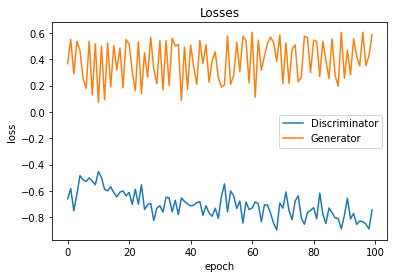

In [66]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

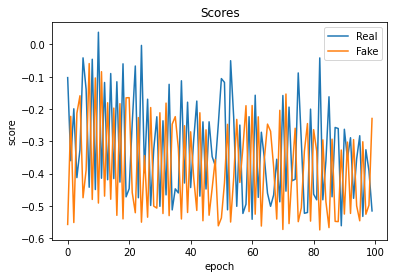

In [67]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
# global gen 
gen = generator
# generator.apply(weight_init)
gen.load_state_dict(torch.load('G200.pth', map_location=torch.device('cpu')))
print(gen)

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)


In [ ]:
len(gen)

14